In [1]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
pers_experiments = "(hostname == 'scyper21' or hostname == 'scyper22')"

libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "llama8-ref", "sortledton", "stinger7-ref", "teseo-lcc.12"]
libraries_filter = " | ".join(map(lambda l: "library == '" + l + "'", libraries))

graphs = ["dota-league", "com-friendster", "graph500-24", "graph500-26", "uniform-24"]
graph_filter = " | ".join(map(lambda l: "graph == '" + l + "'", graphs))

edges_per_graph = pd.DataFrame({
    "graph": ["com-friendster", "dota-league", "graph500-22", 
              "graph500-24", "graph500-26", "uniform-22", 
              "uniform-24", "uniform-26"
              ],
    "edges": [1806067135, 50870313, 64155735, 260379520, 1051922853, 64155735, 260379520, 1051922853]
})

data = common.import_gfe("View_Inserts").query(pers_experiments).copy() # data from the experiments
data["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by
data["block_size"].fillna(-1, inplace=True)
data = data.query("((block_size == 512) and library == 'sortledton') or library != 'sortledton'") 
data = data.merge(edges_per_graph, on="graph")
data["edges_per_second"] = data["edges"] / data["completion_time_secs"]

data = data.query(libraries_filter)
data = data.query(graph_filter)
data = data.query("graph != 'uniform-22'")

In [3]:
data_grouped = data.groupby(["compiler_family", "graph", "library", "build_frequency", "num_threads"]) \
    .agg(min_eps=("edges_per_second", "min"), max_eps=("edges_per_second", "max"), edges_per_second=("edges_per_second", "median"), count=("edges_per_second", "count"))
#data = data.unstack("algorithm")[("completion_time")]
data_grouped.index.set_names("compiler", level=1, inplace=True)
data_grouped

min_eps  \
compiler_family compiler       library                build_frequency num_threads                 
gcc             com-friendster g1_v6-ref-ignore-build 0 days 00:00:00 20           3.415865e+06   
                               livegraph3_ro          0 days 00:00:00 20           3.291848e+05   
                               sortledton             0 days 00:00:00 56           4.605550e+06   
                               teseo-lcc.12           0 days 00:00:00 56           2.692481e+06   
                dota-league    g1_v6-ref-ignore-build 0 days 00:00:00 20           3.179162e+06   
                               livegraph3_ro          0 days 00:00:00 20           3.300097e+05   
                               llama8-ref             0 days 00:00:10 16           3.985747e+05   
                               sortledton             0 days 00:00:00 56           2.031772e+06   
                               stinger7-ref           0 days 00:00:00 56           2.644407e+05   
                               teseo-lcc.12           0 days 00:00:00 56           2.317500e+06   
                graph500-24    g1_v6-ref-ignore-build 0 days 00:00:00 1            1.180921e+06   
                                                                      2            1.383266e+06   
                                                                      4            2.418809e+06   
                                                                      8            2.889757e+06   
                                                                      14           3.386599e+06   
                                                                      20           2.731632e+06   
                                                                      28           3.424617e+06   
                                                                      42           2.800239e+06   
                                                                      56           1.992246e+06   
                               livegraph3_ro          0 days 00:00:00 1            4.483728e+04   
                                                                      2            8.824655e+04   
                                                                      4            1.656193e+05   
                                                                      8            2.609173e+05   
                                                                      14           3.280355e+05   
                                                                      20           3.403248e+05   
                                                                      28           3.447297e+05   
                                                                      42           3.424092e+05   
                                                                      56           3.102290e+05   
                               llama8-ref             0 days 00:00:00 16           2.839284e+04   
                                                      0 days 00:00:10 1            1.295408e+04   
                                                                      2            4.053094e+04   
                                                                      4            9.773502e+04   
                                                                      8            1.979218e+05   
                                                                      14           2.676724e+05   
                                                                      16           2.793308e+05   
                                                                      28           2.811366e+05   
                                                                      42           2.678139e+05   
                                                                      56           2.556201e+05   
                               sortledton             0 days 00:00:00 1            1.875911e+05   
                             

In [8]:
stinger = pd.concat( [
    data_grouped.loc[("gcc", slice(None), "stinger7-ref", slice(None), 56)].droplevel([1])
], names=["library", "graph"], keys=["Stinger"])
llama = pd.concat( [
   data_grouped.loc[("gcc", slice(None), "llama8-ref", "00:00:10", 16)].droplevel([]) # dynamic scheduling in OpenMP
], names=["library","graph"], keys=["LLama"] )
graphone = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "g1_v6-ref-ignore-build", slice(None), 20)].droplevel([1])
],names=["library"], keys=["GraphOne"] )
livegraph = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "livegraph3_ro", slice(None), 20)].droplevel([1])
], names=["library"], keys=["Livegraph"] )
teseo = data_grouped.loc[("gcc", slice(None), "teseo-lcc.12", slice(None), 56)].droplevel([1])
teseo = pd.concat([ pd.concat([teseo], axis=1 ) ], names=["library"], keys=["Teseo"])
sortledton1 = data_grouped.loc[("gcc", slice(None), "sortledton", slice(None), 56)].droplevel([1])
sortledton = pd.concat([ pd.concat([sortledton1], axis=1 ) ], names=["library"], keys=["Sortledton"])
stinger

all_libs = pd.concat([stinger,llama,graphone,livegraph,teseo,sortledton])
all_libs = all_libs.drop("count", axis=1)
#all_libs = all_libs.reindex(index=["graph", "library"])
# Filter out G1 for all powerlaw graphs as they cannot c
all_libs = all_libs.query("(library == 'GraphOne' and graph == 'uniform-24') or library != 'GraphOne'")
all_libs = all_libs.swaplevel(0,1)
all_libs = all_libs.sort_index()
all_libs = all_libs.pivot_table(values="edges_per_second", columns="library", index="graph")

column_order = ["Sortledton", "Teseo", "GraphOne", "Stinger", "LLama", "Livegraph"]
all_libs = all_libs[column_order]

all_libs

library,Sortledton,Teseo,GraphOne,Stinger,LLama,Livegraph
graph,,,,,,
com-friendster,4.769268e+06,2.791274e+06,NaN,NaN,NaN,337243.647201
dota-league,3.706677e+06,2.409672e+06,NaN,2.685775e+05,420655.625370,337659.077717
graph500-24,4.159380e+06,3.072078e+06,NaN,1.063044e+05,287541.723015,344300.397565
graph500-26,3.985641e+06,3.043456e+06,NaN,NaN,NaN,336854.541604
uniform-24,5.568164e+06,3.125488e+06,2.715217e+06,6.336162e+06,278022.922093,335526.353498


<AxesSubplot:ylabel='edges per second [million]'>

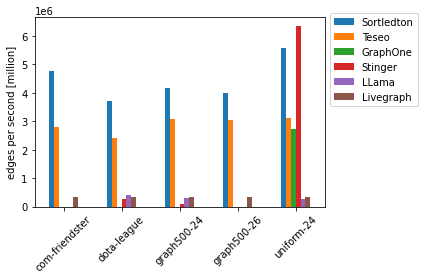

In [9]:
path = os.environ["HOME"] + "/workspace/sortledton-presentation/figures/insertions.png"

p = all_libs.plot.bar()
p.legend(bbox_to_anchor=(1.0, 1.05))
#plt.yscale("log")
#p.set_ylim(1, 100000000)
plt.ylabel("edges per second [million]")
plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(path)

p